# 0. Загружаем бибилиотеки и данные 

In [1]:
# загружаем библиотеки
import warnings
warnings.simplefilter('ignore')

from datetime import datetime
from itertools import combinations
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import icu
import pymorphy2
from gensim import models, corpora  
from nltk import corpus, download as download_sw
import networkx as nx

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set(style='white', context='paper', font_scale=0.95)

# загружаем стоп-слова
stopwords = corpus.stopwords.words('russian')

# random state
RS = 1

# настройки отображения pandas
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
# функции, которые нам понадобятся

def parse_date(s_date, fmt='dd MMMM yyyy'):
    '''Функция для форматирования даты'''
  
    s_date =' '.join(s_date.split()[:3])
    f = icu.SimpleDateFormat(fmt, icu.Locale('ru'))
    return datetime.fromtimestamp(int(f.parse(s_date)))


def prepare_lda_data(data):
    '''Функция для преобразования текста для модели lda'''

    # формируем биграммы и триграммы
    bigram = models.Phrases(data, min_count=2, threshold=50) # higher threshold fewer phrases.
    trigram = models.Phrases(bigram[data], min_count=2, threshold=20)  
    bigram_mod = models.phrases.Phraser(bigram)
    trigram_mod = models.phrases.Phraser(trigram)
    data = [bigram_mod[doc] for doc in data]
    data = [trigram_mod[bigram_mod[doc]] for doc in data]

  # готовим данные для lda
    id2word = corpora.Dictionary(data)
    id2word.filter_extremes(no_below=3)
    corpus = [id2word.doc2bow(text) for text in data]
    return data, id2word, corpus

def format_topics(ldamodel, corpus, texts):
    '''Функция для вывода результатов модели lda'''

    sent_topics = []
    for row in ldamodel[corpus]:       
        topic_num, prop_topic = sorted(row, key=lambda x: x[1], reverse=True)[0]
        topic_keywords = ", ".join([word for word, _ in ldamodel.show_topic(topic_num)])
        sent_topics.append([topic_num, round(prop_topic, 4), topic_keywords])
    
    result = pd.DataFrame(data=sent_topics,
                          columns=['Dominant_Topic', '%_Contribution', 'Topic_Keywords'])
    result['tokens'] = pd.Series(texts)
    return result

def plot_counts(data, title, label, **kwargs):
    '''Функция для визуализации распределений'''

    sns.barplot(x=data.values, y=data.index, orient="h", **kwargs)
    plt.title(title)
    plt.xlabel("Количество обращений")
    plt.ylabel(label)


def fill_area(row, area_dict):
    '''Функция для заполнения названий районов'''

    if len(row["area"]) > 0 or row["street"] == '':
        return row["area"]

    for area in area_dict.index:
        if row["street"] in area_dict[area]:
            return area
    return 'Неизвестн'

def similarity(s1, s2):
    ''' Функция для расчёта похожести ключевых слов для тем'''
    
    if not len(s1) or not len(s2):
        return 0.0
    s1, s2 = set(s1), set(s2)    
    return len(s1.intersection(s2))/(len(s1) + len(s2))

def textrank(sentences):
    ''' Функция для вычисления text rank'''

    pairs = combinations(range(len(sentences)), 2)
    scores = [(i, j, similarity(sentences[i], sentences[j])) for i, j in pairs]
    # фильтруем тех, у кого похожесть = 0
    scores = filter(lambda x: x[2], scores)

    graph = nx.Graph()
    graph.add_weighted_edges_from(scores)
    pr = nx.pagerank(graph)
    return graph, sorted(((i, pr[i], s) for i, s in enumerate(sentences) if i in pr),
                  key=lambda x: pr[x[0]], reverse=True) 

# 1. Exploration data analysis

Загрузим данные в pandas 

In [3]:
df = pd.read_csv(r'D:\data for projects\mosru\Mosru_dump_all_pages.txt', sep="', '",
                 encoding='utf-8',
                 names=['theme', 'text', 'responsible', 'post', 'date'])
print(f'всего обращений {df.shape[0]}')
df.head(10)

всего обращений 90176


,theme,text,responsible,post,date
0,'Сообщение о проблеме «Несоблюдение требований к размещению информационных вывесок» по адресу Сн...,Выше второго этажа,Ларин А.С.,начальник Объединения административно-технических инспекций города Москвы,16 Ноября 2020 в 16:31'
1,'Сообщение о проблеме «Неубранная городская территория» по адресу Снежная улица д.24Д,По адресу Снежная д24 расположена музыкальная школа .На заднем дворе по пр.Нансена возле забор...,Кучма А.А.,глава управы района Свиблово города Москвы,05 Мая 2020 в 15:45'
2,'Сообщение о проблеме «Неубранная городская территория» по адресу Снежная улица д.6,После проведения работ на кабельной канализации МГТС запорные устройства (железобетонные пробки)...,Ларин А.С.,начальник Объединения административно-технических инспекций города Москвы,01 Марта 2020 в 16:57'
3,'Сообщение о проблеме «Неубранная городская территория» по адресу Снежная улица д.24Д,Очистите опору освещения. Приведите в надлежащее состояние.,Кучма А.А.,глава управы района Свиблово города Москвы,16 Января 2020 в 13:54'
4,'Сообщение о проблеме «Захламление территории» по адресу Снежная улица д.1А,Более двух недель лежит куча грунта в перемешку с мусором,Сержантов С.А.,и.о. главы управы района Свиблово города Москвы,24 Августа 2019 в 15:39'
5,'Сообщение о проблеме «Захламление территории» по адресу Снежная улица д.12 с.2,"Осколки бордюрного камня спрятаны за дерево, ветки деревьев на земле",Киселев В.В.,глава управы района Свиблово города Москвы,05 Мая 2019 в 09:11'
6,'Сообщение о проблеме «Несоблюдение требований к размещению информационных вывесок» по адресу Сн...,Прошу рассмотреть законность размещения вывески \\,Киселев В.В.,глава управы района Свиблово города Москвы,06 Февраля 2019 в 10:29'
7,'Сообщение о проблеме «Несоблюдение требований к размещению информационных вывесок» по адресу Сн...,Просьба проверить законность размещения информационной конструкции \\,Баранов Н.П.,глава управы района Свиблово города Москвы,05 Октября 2018 в 12:03'
8,'Сообщение о проблеме «Несоблюдение требований к размещению информационных вывесок» по адресу Сн...,Здравствуйте! Прошу проверить законность установки информационной вывески по адресу Снежная улиц...,Баранов Н.П.,глава управы района Свиблово города Москвы,22 Марта 2018 в 15:15'
9,'Сообщение о проблеме «Отсутствие информационного щита» по адресу Снежная улица д.6,Отсутствуют информационные щиты на всех подобных площадках по замене остановок в Свиблово.,Семенов П.В.,"генеральный директор Государственного бюджетного учреждения города Москвы ""Городская реклама и ...",05 Сентября 2017 в 17:29'


С учётом структуры данных в нашей таблице выполним следующие преобразования:

1) Преобразуем дату обращения в datetime с помощью специальной функции.

2) В признаке theme содержится краткое содержание проблемы и адрес события. Выделим эти сущности в два новых признака problem и adress. Удалим ненужные символы в этих признаках.

3) Выделим район проблемы в отдельный признак (area)

 Полученный результат запишем в новый датафрейм, куда добавим ещё и признак text из оригинального.

In [4]:
# метод assign добавляет новые признаки к массиву
prepared = (pd.DataFrame(index=df.index)
               .assign(date=df['date'].apply(lambda x: parse_date(s_date=x)),
                                        # разбиваем признак theme на 2 части 
                       problem=(df['theme'].str.split('по адресу', expand=True)[0]
                                          # выделяем содержание проблемы
                                           .str.extract(r'(«.*?»)')
                                          # убираем ненужные символы
                                           .replace(r'«|»|\\', '', regex=True)
                                           ),
                       adress=df['theme'].str.split('по адресу', expand=True)[1],          
                       area=(df['post'].str.findall(r'(?<=управы )(.*)(?= района)|(?<=района)(.*)(?=города)', 
                                                   flags=re.IGNORECASE)
                                     # меняем тип данных (для удобства)
                                       .astype('str')
                                     # убираем ненужные символы
                                       .str.replace(r'\W', '', regex=True)),                                          
                       text=df['text'])              
            )
# удалим дубли
prepared.drop_duplicates(inplace=True, ignore_index=True)
print(f'всего обращений после удаления дубликатов {prepared.shape[0]}')
prepared.head(10) 

всего обращений после удаления дубликатов 89603


,date,problem,adress,area,text
0,2020-11-16,Несоблюдение требований к размещению информационных вывесок,Снежная улица д.26,,Выше второго этажа
1,2020-05-05,Неубранная городская территория,Снежная улица д.24Д,Свиблово,По адресу Снежная д24 расположена музыкальная школа .На заднем дворе по пр.Нансена возле забор...
2,2020-03-01,Неубранная городская территория,Снежная улица д.6,,После проведения работ на кабельной канализации МГТС запорные устройства (железобетонные пробки)...
3,2020-01-16,Неубранная городская территория,Снежная улица д.24Д,Свиблово,Очистите опору освещения. Приведите в надлежащее состояние.
4,2019-08-24,Захламление территории,Снежная улица д.1А,Свиблово,Более двух недель лежит куча грунта в перемешку с мусором
5,2019-05-05,Захламление территории,Снежная улица д.12 с.2,Свиблово,"Осколки бордюрного камня спрятаны за дерево, ветки деревьев на земле"
6,2019-02-06,Несоблюдение требований к размещению информационных вывесок,Снежная улица д.26,Свиблово,Прошу рассмотреть законность размещения вывески \\
7,2018-10-05,Несоблюдение требований к размещению информационных вывесок,Снежная улица д.26,Свиблово,Просьба проверить законность размещения информационной конструкции \\
8,2018-03-22,Несоблюдение требований к размещению информационных вывесок,Снежная улица д.23,Свиблово,Здравствуйте! Прошу проверить законность установки информационной вывески по адресу Снежная улиц...
9,2017-09-05,Отсутствие информационного щита,Снежная улица д.6,,Отсутствуют информационные щиты на всех подобных площадках по замене остановок в Свиблово.


Востановим названия районов из названий улиц. Стоит отметить, что в некоторых случаях восстановление проводится некорректно. Для исправления этого необходима более глубокая предобработка данных с исправлением ошибок.

In [5]:
prepared['street'] = (prepared['adress'].str.findall(r'([А-Я][а-яё]+)')
                                        .apply(lambda x: ' '.join(x)))

# словарь район-улицы
area_dict = (prepared.loc[prepared['area'] != '']
                     .groupby('area')['street'].apply(lambda x: set(x)))

prepared['area'] = prepared.apply(lambda row: fill_area(row, area_dict), axis=1)

## Количество обращений по районам

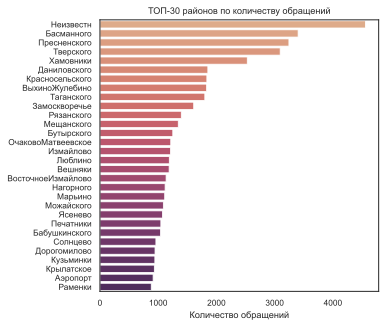

In [6]:
plt.figure(figsize=(5,5))
plot_counts(data=prepared['area'].value_counts()[:30], 
            title="ТОП-30 районов по количеству обращений", 
            label=None,
            palette="flare")

## Проанилизирем завимость количества обращений от времени

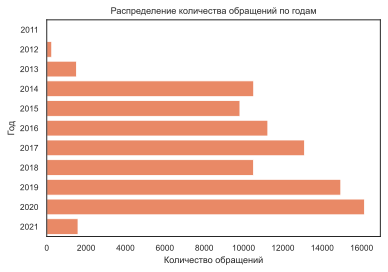

In [7]:
plot_counts(data=prepared.groupby(prepared['date'].dt.year)['date'].count(), 
            title="Распределение количества обращений по годам", 
            label="Год",
            color="coral")

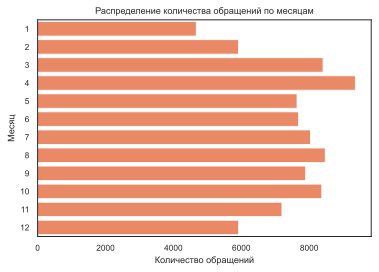

In [8]:
month_count = prepared.groupby(prepared['date'].dt.month)['date'].count()
plot_counts(data=month_count, 
            title="Распределение количества обращений по месяцам", 
            label="Месяц",
            color="coral")

## Рассмотрим подробнее темы обращений

Самые популярные темы (топ-15)

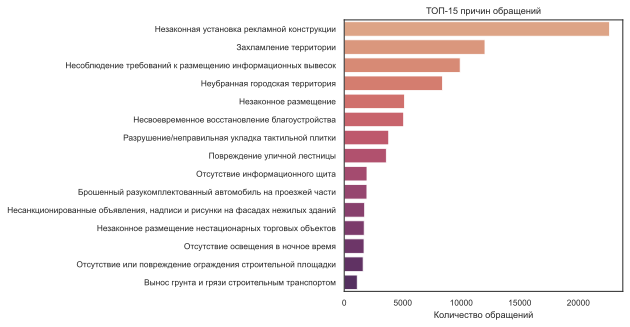

In [9]:
# top 15
plt.figure(figsize=(5,5))
plot_counts(data=prepared["problem"].value_counts()[:15], 
            title="ТОП-15 причин обращений",
            label=None,
            palette="flare")

Посмотрим динамику топ-10 тем обращений по годам

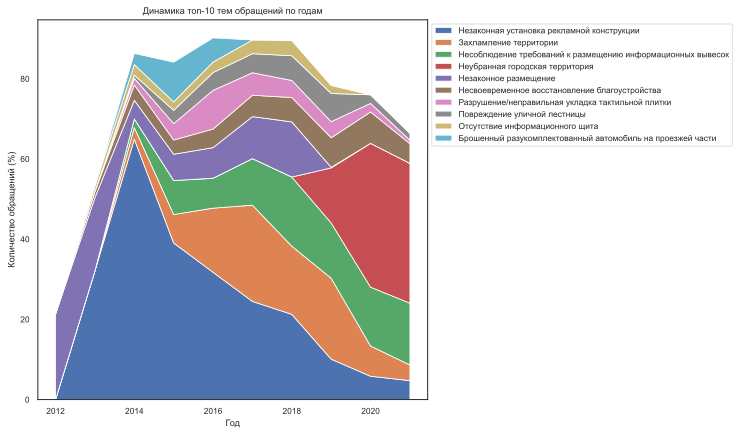

In [10]:
# сводная таблица
years_crosstab = (pd.crosstab(prepared['problem'], 
                              prepared['date'].dt.year, 
                              normalize='columns').drop([2011], axis=1)
                       # выберем топ 10 
                   .loc[prepared['problem'].value_counts()[:10].index]*100)        

plt.figure(figsize=(7,7))
plt.stackplot(years_crosstab.columns, years_crosstab.values,
              labels=years_crosstab.index)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Динамика топ-10 тем обращений по годам')
plt.xlabel('Год')
plt.ylabel('Количество обращений (%)');

И динамику топ-10 тем обращений по месяцам

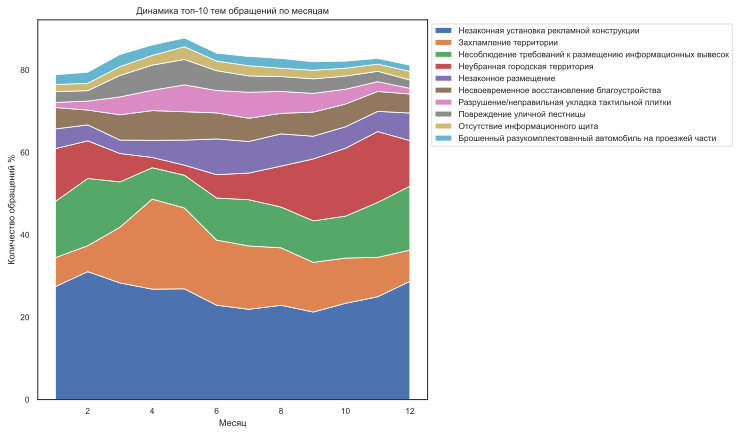

In [11]:
# сводная таблица
month_crosstab = (pd.crosstab(prepared['problem'], 
                              prepared['date'].dt.month, 
                              normalize='columns')
                    # выберем топ 10 
                   .loc[prepared['problem'].value_counts()[:10].index]*100)        

plt.figure(figsize=(7,7))
plt.stackplot(month_crosstab.columns,
              month_crosstab.values,
              labels=month_crosstab.index)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Динамика топ-10 тем обращений по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество обращений %');

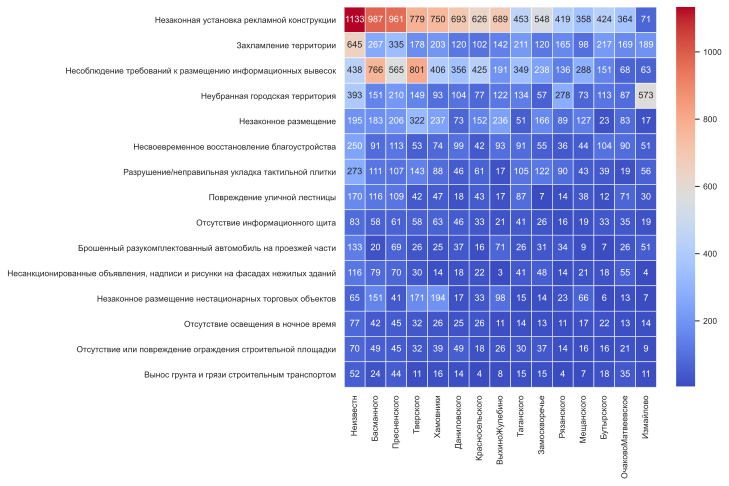

In [12]:
# построим тепловую карту причин обращения и районов (топ-15)

area_problem_crosstab = (pd.crosstab(prepared['problem'], 
                                     prepared['area'])
                           .loc[prepared['problem'].value_counts()[:15].index,  
                                prepared['area'].value_counts()[:15].index])
plt.figure(figsize=(7,7))
sns.heatmap(area_problem_crosstab, cmap="coolwarm",
            annot=True, fmt=".0f", linewidths=.5);

# 2. Тематическое моделирование

Подготовим данные для тематического моделирования. Проведём очистку текста обращения от ненужных символов и выполним лемматизацию. 

In [13]:
# готовим данные для lda
morph = pymorphy2.MorphAnalyzer()
tokens = (prepared['text'].str.lower().replace('[^а-я-ё]|-', ' ', regex=True)
                          .apply(lambda x: [morph.parse(word)[0].normal_form for word in x.split(' ')
                                            if len(word) > 2 and word not in stopwords])
                          ).tolist()

tokens, dictionary, all_corpus = prepare_lda_data(data=tokens)

# строим модель lda
# можно ускорить процесс, используя ldamulticore
# но обычный вариант более стабильный 
lda_model = models.ldamodel.LdaModel(corpus=all_corpus, 
                                     num_topics=40, 
                                     id2word=dictionary,
                                     random_state=RS)
# посмотрим первые 10 слов по первым темам
lda_model.show_topics(num_topics=10, num_words=10, formatted=True)

[(10,
  '0.090*"городской" + 0.060*"должный" + 0.059*"район" + 0.050*"другой" + 0.045*"рабочий" + 0.037*"пройти" + 0.027*"детский_сад" + 0.024*"это" + 0.024*"блок" + 0.023*"проводиться"'),
 (5,
  '0.092*"лежать" + 0.069*"дерево" + 0.046*"месяц" + 0.044*"мусор" + 0.044*"наш" + 0.038*"гора" + 0.037*"житель" + 0.035*"метр" + 0.031*"который" + 0.028*"это"'),
 (25,
  '0.194*"место" + 0.138*"отсутствовать" + 0.099*"освещение" + 0.063*"работа" + 0.053*"ограждение" + 0.038*"провести" + 0.036*"выполнить" + 0.031*"разрытие" + 0.024*"сам" + 0.023*"отход"'),
 (23,
  '0.134*"около" + 0.107*"баннер" + 0.087*"дом" + 0.076*"подъезд" + 0.075*"возле" + 0.055*"остановка" + 0.053*"состояние" + 0.038*"добрый_день" + 0.032*"корп" + 0.023*"иметься"'),
 (9,
  '0.146*"разместить" + 0.132*"проверить" + 0.084*"висеть" + 0.046*"прежний_место" + 0.045*"разрешение" + 0.043*"торговать" + 0.042*"огромный" + 0.041*"просить" + 0.040*"несанкционированный" + 0.030*"нестационарный_торговый_объект"'),
 (38,
  '0.266*"вывес

Посмотрим результаты работы модели для каждого сообщения. 

In [14]:
# результат по каждому сообщению
result_lda = format_topics(ldamodel=lda_model, corpus=all_corpus, texts=tokens)
result_lda.head()

,Dominant_Topic,%_Contribution,Topic_Keywords,tokens
0,0,0.0250,"размещение, проверить_законность, просить, рекламный, конструкция, фасад, заменить, разрушение_т...",[выше_второй_этаж]
1,12,0.2717,"вид, такой, ям, больший, бордюр, вообще, ответ, закрепить, возможно, невозможно","[адрес, снежный, расположить, музыкальный_школа, задний, двор, нансен, возле, забор, иметься, пр..."
2,20,0.5999,"газон, восстановить, магазин, пожалуйста, необходимо, бросить, сломать, табличка, дорожка, асфальт","[проведение_работа, кабельный, канализация, мгтс, запорный, устройство, железобетонный, пробка, ..."
3,32,0.6049,"повредить, ступень, лестница, уличный_лестница, частично, пешеход, металлический, привести, надл...","[очистить, опора_освещение, привести, надлежащий_состояние]"
4,35,0.3454,"мусор, территория, строительный, захламление, убрать, куча, свалка, хлам, бытовой, вывезти","[два_неделя, лежать, куча, грунт_перемешок, мусор]"


# 3. Анализ результатов lda 

Проведём анализ тем lda. Для этого преобразуем ключевые слова для каждой темы в граф с помощью алгоритма text rank. Связь между темами будет определяться по количеству общих ключевых слов, которое учитывается в весах рёбер.
Визуализируем получившийся граф. Размер вершины будет зависить от количества входящих в неё ребёр, а цвет от их веса.      

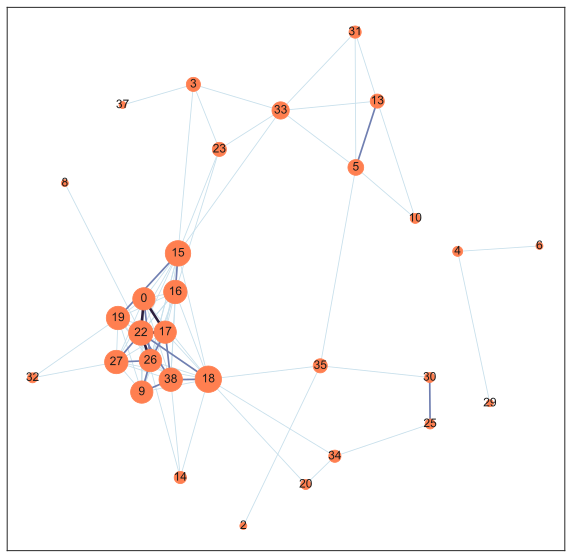

In [15]:
# ключевые слова для text rank
keywords = [[word for word, _ in lda_model.show_topic(num, topn=10)] 
            for num in range(lda_model.num_topics)]

kw_graph, _ = textrank(keywords)

# построим граф
plt.figure(figsize=(10,10))
pos = nx.spring_layout(kw_graph, seed=7)
# вершины
nx.draw_networkx_nodes(kw_graph, pos=pos,  
                       node_color='coral',
                       node_size=[v * 50 for v in dict(nx.degree(kw_graph)).values()])
# обозначения                                                                              
nx.draw_networkx_labels(kw_graph, pos=pos, font_size=12)

# веса
all_weights = [data['weight'] for _, _, data in kw_graph.edges(data=True)]
edge_colors = sns.color_palette("ch:s=.25,rot=-.25", n_colors=len(set(all_weights)))
for i, weight in enumerate(set(all_weights)):
    weighted_edges = [(node1, node2) for (node1, node2, edge_attr) in kw_graph.edges(data=True) 
                      if edge_attr['weight']==weight]

    width = weight * kw_graph.number_of_nodes() * 3 / np.sum(all_weights)
    nx.draw_networkx_edges(kw_graph, pos=pos, edgelist=weighted_edges, width=width, edge_color=edge_colors[i])

Стоит отметить, что присутствуют темы, которые не имеют общих слов с другими, поэтому они не попали на граф. Посмотрим на них:

In [16]:
for theme in set(range(40)).difference(dict(nx.degree(kw_graph)).keys()):
    print('тема {}: \n{}\n'.format(theme, lda_model.show_topic(theme)))

тема 1: 
[('разрушить', 0.06682511), ('жилой_дом', 0.06677326), ('стена', 0.057640437), ('полностью', 0.052563038), ('просто', 0.044087056), ('иметь', 0.0343121), ('факт', 0.03161625), ('материал', 0.021965344), ('обочина', 0.018784622), ('лицо', 0.018319681)]

тема 7: 
[('просить_принять_мера', 0.08687804), ('грунт', 0.06512519), ('день', 0.058476523), ('принять_мера', 0.05632427), ('незаконно', 0.053727135), ('работать', 0.051591765), ('появиться', 0.042185973), ('происходить', 0.033833098), ('жалоба', 0.02962503), ('основание', 0.024045188)]

тема 11: 
[('убираться', 0.10623071), ('стройплощадка', 0.092508666), ('навести_порядок', 0.06486561), ('парк', 0.05286022), ('город_москва', 0.038349945), ('вести', 0.035049293), ('забросить', 0.031995915), ('бутылка', 0.031809513), ('незаконно_разместить', 0.030214243), ('везде', 0.028052177)]

тема 12: 
[('вид', 0.081463054), ('такой', 0.06471311), ('ям', 0.053372663), ('больший', 0.03905606), ('бордюр', 0.038805768), ('вообще', 0.03753168),

# 4. Дальнейшие улучшения

1. Провести более глубокую предобработку данных.
2. Построить новые признаки, добавить данные, провести более детальный анализ. 
3. Настроить параметры lda модели.
4. Попробовать языковые модели.
5. Попробовать другие алгоритмы ранжирования тем.